# Problem C: Prediction of Traffic Flow based on Burgers’ Equation Model
Burgers' equation is a mathematical model used in various fields, including traffic flow, to represent the behavior of nonlinear systems with both convective and diffusive effects. In traffic flow, it captures the interactions between vehicles, such as the tendency for traffic to slow down when density increases (convection) and the tendency for traffic to spread out due to individual driver behavior (diffusion).

The Burger's Equation for modeling traffic flow is given as follows:
\begin{equation}
u_t + uu_x = \nu u_{xx}, \quad x\in (-1,1),\ t\in(0,1]
\end{equation}
Where:
- $u(x,t)$: car velocity (m/s),
- $\nu$: a diffusion coefficient (reflecting how drivers respond to nearby traffic; higher $\nu$ = more cautious drivers),
- $x$: position along the road,
- $t$: time.

We set $\nu=0.1$ and consider the Dirichlet boundary condition, i.e.:
$$
u(x=-1, t) = u(x=1, t)=0,\quad t\in(0,1]
$$

With this PDE model, once the initial velocity field $u(x,t=0)=a(x)$ is given, we can predict the velocity field $u(x,t)$ at any time $t>0$ by solving Burger's equation.

## Task: predicting the velocity filed $u(x,t)$ given the inital field $u(x,t=0)=a(x)$
In this task, we have collected many initial field $u(x,t=0)=a(x)$ which are sampled from a distribution $\mathcal{A}$. We have also computed the corresponding velocity field $u(x,t)$ by solving Burger's equation with a high-precision FDM method. Now, we hope to make a fast prediction of the velocity field $u(x,t)$ once a new initial condition $a(x)$ is given from the same distribution.

### The goals
- Please select a suitable deep learning method for solving this task, and explain the reason for using it
- Report your setups for the implementation, such as network structure, activation function, optimizer (with learning rate), epoch (with batch size), loss weights, and other tricks that are used for improvement.
- Compute the $L^2$ relative error (on testing dataset) at each training epoch and plot the ```Error vs. epcoh``` curve (and report the final error). The $L^2$ relative error between the prediction $\{u^{(j)}_{pred}\}^{N}_{j}$ and the truth $\{u^{(j)}_{true}\}^{N}_j$ is defined as follows:
  $$error = \frac{1}{N}\sum_j\sqrt{\frac{\sum_i|u^{(j)}_{pred}(x_i, t_i)-u^{(j)}_{true}(x_i,t_i)|^2}{\sum_i|u^{(j)}_{true}(x_i, t_i)|^2}}$$
 where $j$ indicates the $j$-th instance.
- Plot the initial field, the corresponding predicted solution (and the ground truth reference), and the pointwise absolute error for the first instance in the testing Dataset using separate figures with ```matplotlib```.

### Dataset
The observation and the ground truth references are given in the dataset ```TrafficFlow.h5```:
- ```a_train```: size(1000, 128), the collected $N=1000$ initial fields (on $128$ sensors)
- ```u_train```: size(1000, 100, 128), the collected $N=1000$ velocity fields (on $100\times 128$ temporal-spatial regular meshgrids)
- ```a_test```: size(200, 128), the initial fields that we are going to predict their corresponding velocity field (Should not be used for training)
- ```u_test```: size(200, 100, 128), the ground truth reference of the velocity field (Should not be used for training)
- ```x_mesh```: size(128, 1), the spatial-coordiante of locations where the velocity field computed
- ```t_mesh```: size(100, 1), the temporal-coordiante of locations where the velocity field computed
- Link to dataset: [https://www.kaggle.com/datasets/yhzang32/dno4pdes](https://www.kaggle.com/datasets/yhzang32/dno4pdes)

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

Using device: cuda
<KeysViewHDF5 ['a_test', 'a_train', 't_mesh', 'u_test', 'u_train', 'x_mesh']>
The shape of t_mesh: torch.Size([100, 1])
The shape of x_mesh: torch.Size([128, 1])
The shape of a_test: torch.Size([200, 128])
The shape of u_test: torch.Size([200, 100, 128])
The shape of a_train: torch.Size([1000, 128])
The shape of u_train: torch.Size([1000, 100, 128])


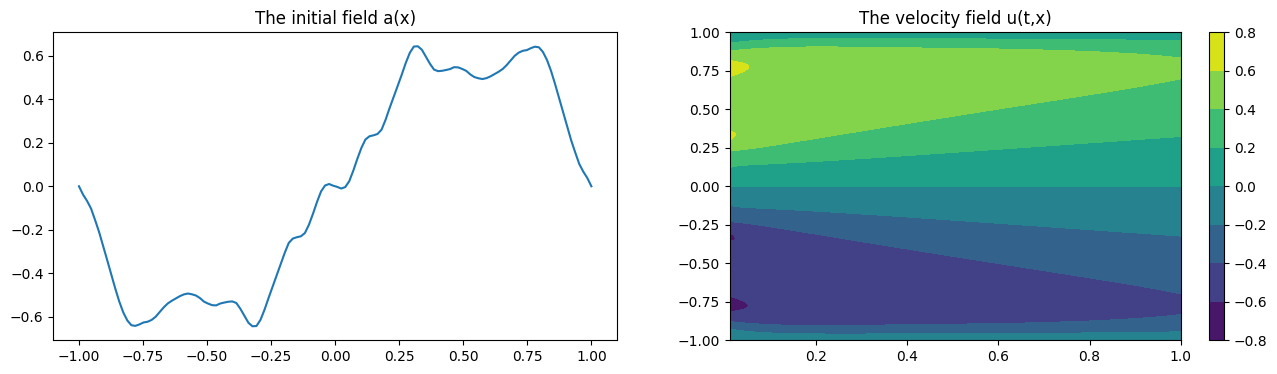

In [2]:
import numpy as np
import h5py
import torch
import matplotlib.pyplot as plt
dtype = torch.float32

torch.cuda.is_available()

# Set device for PyTorch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

######################################
# Load training data
######################################
filepath = '/kaggle/input/traffic-flow/TrafficFlow.h5'
with h5py.File(filepath, 'r') as file:
    print(file.keys())
    t_mesh = torch.tensor(np.array(file['t_mesh']), dtype=dtype)
    x_mesh = torch.tensor(np.array(file['x_mesh']), dtype=dtype)
    a_test = torch.tensor(np.array(file['a_test']), dtype=dtype)
    u_test = torch.tensor(np.array(file['u_test']), dtype=dtype)
    a_train = torch.tensor(np.array(file['a_train']), dtype=dtype)
    u_train = torch.tensor(np.array(file['u_train']), dtype=dtype)
    #
    X, T = np.meshgrid(x_mesh, t_mesh)
#
print('The shape of t_mesh:',t_mesh.shape)
print('The shape of x_mesh:',x_mesh.shape)
print('The shape of a_test:',a_test.shape)
print('The shape of u_test:',u_test.shape)
print('The shape of a_train:',a_train.shape)
print('The shape of u_train:',u_train.shape)
#################################
inx = 0
fig, axes = plt.subplots(1,2, figsize=(16,4))
#
cntr = axes[0].plot(x_mesh, a_train[0])
axes[0].set_title('The initial field a(x)')
#
cntr = axes[1].contourf(T, X, u_train[inx])
axes[1].set_title('The velocity field u(t,x)')
plt.colorbar(cntr)
#
plt.show()

In [3]:
# Combine the input coordinates and k(x) -> kx_train = [k(x)], x, y]
ndata_train = a_train.shape[0]
ndata_test = a_test.shape[0]

T, X = torch.meshgrid(t_mesh.squeeze(), x_mesh.squeeze(), indexing='ij')  # indexing ='ij' = [time_index, space_index]

# 2. create a space-timeframe
grid_tx = torch.stack([T, X], dim=-1) # torch.Size([t, x, 2]) On each point we have two values t, x

# Repeat coordinates for all samples
x_train = grid_tx.unsqueeze(0).repeat(ndata_train, 1, 1, 1)
x_test = grid_tx.unsqueeze(0).repeat(ndata_test, 1, 1, 1)

# broadcast a(x) to (t,x) each t gets the same a(x). a(x) = u(x,t=0)
a_train_expanded = a_train.unsqueeze(1).repeat(1, 100, 1)  # [1000, 100, 128]
a_test_expanded = a_test.unsqueeze(1).repeat(1, 100, 1)

a_train_expanded = a_train_expanded.unsqueeze(-1)         # [1000, 100, 128, 1]
a_test_expanded = a_test_expanded.unsqueeze(-1)

# Erklärung:
# x_train entält für jedes der 1000 Sampels die x, t koordianten für jeden Punkt [1000, 100, 128, 2]
# a_train_expanded erweitert a_train ([1000, 128])(1000 Samples, 128 Sensors) über alle zeitschritte hinweg. Damit verfügt jeder Zeitschritt über die selben startbedigungen
# ax_train combiniert beides: für alle x_train mit [1000, 100, 128, 2] wird zusätzlich noch die Startbedigungn hinzugefügt: a_train_expanded [1000, 100, 128, 1] was dann ax_train ergbibt: [200, 100, 128, 3]
# Weil das Ziel ist: Für ein beliebige Startbedigungung a(x) den zustand zu einem beliebigen Zeitpunkt u(x,t) vorherzusagen
ax_train = torch.cat([a_train_expanded, x_train], dim=-1)  # [1000, 100, 128, 3]
ax_test = torch.cat([a_test_expanded, x_test], dim=-1)

print('The shape of grid_tx:', grid_tx.shape)
print('The shape of x_train:', x_train.shape)
print('The shape of x_test:', x_test.shape)
print('The shape of a_train_expanded:', a_train_expanded.shape)
print('The shape of a_test_expanded:', a_test_expanded.shape)
print('The shape of a_train_expanded:', a_train_expanded.shape)
print('The shape of a_train_expanded:', a_train_expanded.shape)
print('The shape of input_train:', ax_train.shape)
print('The shape of input_test:', ax_test.shape)

The shape of grid_tx: torch.Size([100, 128, 2])
The shape of x_train: torch.Size([1000, 100, 128, 2])
The shape of x_test: torch.Size([200, 100, 128, 2])
The shape of a_train_expanded: torch.Size([1000, 100, 128, 1])
The shape of a_test_expanded: torch.Size([200, 100, 128, 1])
The shape of a_train_expanded: torch.Size([1000, 100, 128, 1])
The shape of a_train_expanded: torch.Size([1000, 100, 128, 1])
The shape of input_train: torch.Size([1000, 100, 128, 3])
The shape of input_test: torch.Size([200, 100, 128, 3])


In [4]:
from torch.utils.data import random_split, TensorDataset

dataset = TensorDataset(ax_train, u_train)
train_set, val_set = random_split(dataset, [800, 200])

# Optional: wieder in Tensoren umwandeln
ax_train, u_train = train_set[:][0], train_set[:][1]
ax_train_val, u_train_val = val_set[:][0], val_set[:][1]

print(ax_train.shape)
print(u_train.shape)
u_train = u_train.unsqueeze(-1)
u_test = u_test.unsqueeze(-1)

print(ax_train_val.shape)
print(u_train_val.shape)

torch.Size([800, 100, 128, 3])
torch.Size([800, 100, 128])
torch.Size([200, 100, 128, 3])
torch.Size([200, 100, 128])


In [5]:
import torch.nn as nn

class SpectralConv2d(nn.Module):
    def __init__(self, in_size, out_size, modes1, modes2, dtype):
        super(SpectralConv2d, self).__init__()

        self.in_size = in_size
        self.out_size = out_size
        self.modes1 = modes1
        self.modes2 = modes2


        self.scale = 1./(in_size * out_size)

        if (dtype is None) or (dtype==torch.float32):
            ctype = torch.complex64
        elif (dtype==torch.float64):
            ctype = torch.complex128
        else:
            raise TypeError(f'No such data type.')


        self.weight1 = nn.Parameter(self.scale * torch.rand(in_size, out_size, self.modes1, self.modes2, dtype=ctype)) # lower frequencies
        self.weight2 = nn.Parameter(self.scale * torch.rand(in_size, out_size, self.modes1, self.modes2, dtype=ctype)) # high frequencies


    # Helper function to multiply matrices
    def compl_mul_2d(self, input, weights):
        '''Complex multiplication: (batch_size, in_size, m1, m2) * (in_size, out_size, m1, m2) -> (batch_size, out_size, m1, m2)
        '''
        return torch.einsum('bixy,ioxy->boxy', input, weights)



    def forward(self, x):


      batch_size = x.shape[0]

      x_ft = torch.fft.rfft2(x)

      out_ft = torch.zeros(batch_size, self.out_size, x.size(-2), x.size(-1)//2+1,device=x.device, dtype=torch.cfloat)

      out_ft[:, :, :self.modes1, :self.modes2] = self.compl_mul_2d(x_ft[:, :, :self.modes1, :self.modes2], self.weight1)
      out_ft[:, :, -self.modes1:, :self.modes2] = self.compl_mul_2d(x_ft[:, :, -self.modes1:, :self.modes2], self.weight2)

      x = torch.fft.irfft2(out_ft, s=(x.size(-2), x.size(-1))) # size(batch_size, out_size, mx_size, my_size)

      return x



class FNO2d(nn.Module):

    def __init__(self, in_size:int, out_size:int, modes1:int, modes2:int,
                 hidden_list:list[int], dtype=None):
        super(FNO2d, self).__init__()
        self.hidden_list = hidden_list
        # Activation
        self.activation = nn.ReLU()
        # The input layer:
        self.fc_in = nn.Linear(in_size, hidden_list[0], dtype=dtype)
        # The hidden layer
        conv_net, w_net = [], []
        self.hidden_in = hidden_list[0]
        for hidden in hidden_list:
            conv_net.append(SpectralConv2d(self.hidden_in, hidden, modes1, modes2, dtype))
            w_net.append(nn.Conv1d(self.hidden_in, hidden, 1, dtype=dtype))
            self.hidden_in =  hidden
        self.spectral_conv = nn.Sequential(*conv_net)
        self.weight_conv = nn.Sequential(*w_net)
        # The output layer
        self.fc_out0 = nn.Linear(self.hidden_in, 128, dtype=dtype)
        self.fc_out1 = nn.Linear(128, out_size, dtype=dtype)


    def forward(self, ax):

          batch_size = ax.shape[0]

          mx_size, my_size = ax.shape[1], ax.shape[2]

          ax = self.fc_in(ax)
          ax = ax.permute(0, 3, 1, 2)

          # The spectral conv layer
          for conv, weight, hidden_size in zip(self.spectral_conv, self.weight_conv, self.hidden_list):
            ax1 = conv(ax)   # size(b, hidden_size, my_size, mx_size)
            ax2 = weight(ax.view(batch_size, hidden_size, -1)).view(batch_size, hidden_size, mx_size, my_size)
            ax = self.activation(ax1+ax2)
          # The output layer: size(batch_size, hidden_size, my_size, mx_size) -> size(batch_size, my_size, mx_size, out_size)
          ax = ax.permute(0, 2, 3, 1)
          ax = self.fc_out0(ax)
          ax = self.activation(ax)

          return self.fc_out1(ax)

# defines number of considered fourier components
mode1 = 8 # first 8 in vertical direction
mode2 = 8 # first 8 in horizontal direction

hidden_list = [45, 45, 45]
model_u = FNO2d(ax_train.shape[-1], u_train.shape[-1], mode1, mode2, hidden_list).to(device)
################## Find total trainable parameters
total_trainable_params = sum(p.numel() for p in model_u.parameters() if p.requires_grad)
print(f'{total_trainable_params:,} training parameters.')

790,007 training parameters.


In [6]:
print('Input size:',ax_train.shape[-1])
print('Output size:',u_train.shape[-1])

Input size: 3
Output size: 1


In [7]:
class LossClass(object):

    def __init__(self, u_model):
        self.device = device
        self.u_model = u_model

    def loss_data(self, ax_batch, u_batch):
        '''loss term'''
        batch_size = u_batch.shape[0]
        ax = ax_batch.to(self.device)
        u = u_batch.to(self.device)
        #
        u_pred = self.u_model(ax)
        loss = torch.norm(u.reshape(batch_size, -1)-u_pred.reshape(batch_size, -1), 2, 1)
        loss = torch.mean(loss)

        return loss



In [8]:
from torch.utils.data import Dataset, DataLoader
############# Define your own dataset
class MyDataset(Dataset):

    def __init__(self, ax:torch.tensor, u:torch.tensor):
        '''
        Input:
            ax: size(batch_size, a_size+x_size)
            u: size(batch_size, u_size)
        '''
        self.ax = ax
        self.u = u

    def __getitem__(self, index):
        return self.ax[index], self.u[index]

    def __len__(self):
        return self.ax.shape[0]

##############
train_loader = DataLoader(MyDataset(ax_train, u_train), batch_size=50, shuffle=True)
val_loader = DataLoader(MyDataset(ax_train_val, u_train_val), batch_size=50, shuffle=True)
for ux_batch, T_batch in train_loader:
    print('ux_batch shape:', ux_batch.shape, 'T_batch shape:', T_batch.shape)
print()
for ux_batch, T_batch in val_loader:
    print('ux_batch shape:', ux_batch.shape, 'T_batch shape:', T_batch.shape)

ux_batch shape: torch.Size([50, 100, 128, 3]) T_batch shape: torch.Size([50, 100, 128, 1])
ux_batch shape: torch.Size([50, 100, 128, 3]) T_batch shape: torch.Size([50, 100, 128, 1])
ux_batch shape: torch.Size([50, 100, 128, 3]) T_batch shape: torch.Size([50, 100, 128, 1])
ux_batch shape: torch.Size([50, 100, 128, 3]) T_batch shape: torch.Size([50, 100, 128, 1])
ux_batch shape: torch.Size([50, 100, 128, 3]) T_batch shape: torch.Size([50, 100, 128, 1])
ux_batch shape: torch.Size([50, 100, 128, 3]) T_batch shape: torch.Size([50, 100, 128, 1])
ux_batch shape: torch.Size([50, 100, 128, 3]) T_batch shape: torch.Size([50, 100, 128, 1])
ux_batch shape: torch.Size([50, 100, 128, 3]) T_batch shape: torch.Size([50, 100, 128, 1])
ux_batch shape: torch.Size([50, 100, 128, 3]) T_batch shape: torch.Size([50, 100, 128, 1])
ux_batch shape: torch.Size([50, 100, 128, 3]) T_batch shape: torch.Size([50, 100, 128, 1])
ux_batch shape: torch.Size([50, 100, 128, 3]) T_batch shape: torch.Size([50, 100, 128, 1])

In [9]:
from tqdm import trange
import time
############ Training setups
epochs = 2000
lr = 1e-3
optimizer = torch.optim.Adam(params=model_u.parameters(), lr=lr, weight_decay=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=np.int32(epochs/4), gamma=0.5)
loss_list = []

best_model = None
best_val_loss = 1e6
early_stopping = 30
min_delta = 1e-4
early_stopping_epoch = 0

loss_list = []
val_loss_list = []

############ The training process
t0 = time.time()
for epoch in trange(epochs):

    model_u.train()

    train_loss_per_epoch = 0

    for ax_batch, u_batch in train_loader:

      optimizer.zero_grad()
      lossClass = LossClass(model_u)
      loss_train = lossClass.loss_data(ax_batch, u_batch)

      train_loss_per_epoch += loss_train.item()
      
      loss_train.backward()
      optimizer.step()
      scheduler.step()

    loss_list.append(train_loss_per_epoch/len(train_loader))
    if (epoch+1)%100==0:
        print(f'\n Epoch:{epoch}, The training loss is:{loss_list[-1]}')

    model_u.eval()

    #
    with torch.no_grad():

      val_loss_per_epoch = 0

      for ax_batch, u_batch in val_loader:

        loss_val = lossClass.loss_data(ax_batch, u_batch)
        val_loss_per_epoch += loss_val.item()

      val_loss_list.append(val_loss_per_epoch/len(val_loader))
      if (epoch+1)%100==0:
          print(f'\n Epoch:{epoch}, The validation loss is:{val_loss_list[-1]}')  

      early_stopping_epoch += 1
      if val_loss_per_epoch <= best_val_loss:
        best_val_loss = val_loss_per_epoch
        best_model_weights = model_u.state_dict() # save the weights
        best_epoch = epoch
        early_stopping_epoch = 0 # Rest
      if early_stopping_epoch > early_stopping:
        break


    

    if (epoch+1)%10==0:
        print(f'Epoch:{epoch}, The loss is:{loss_train.item()},The validation loss is: {loss_val.item()} ,lr: {scheduler.optimizer.param_groups[0]["lr"]}')
print('The consuming time is:', time.time()-t0)
print(f"Loading model from epoch {best_epoch}")
model_u.load_state_dict(best_model_weights)

  0%|          | 10/2000 [00:31<1:39:30,  3.00s/it]

Epoch:9, The loss is:0.901027500629425,The validation loss is: 1.0633784532546997 ,lr: 0.001


  1%|          | 20/2000 [01:01<1:38:28,  2.98s/it]

Epoch:19, The loss is:0.6176224946975708,The validation loss is: 0.7250183820724487 ,lr: 0.001


  2%|▏         | 30/2000 [01:31<1:38:58,  3.01s/it]

Epoch:29, The loss is:0.7207969427108765,The validation loss is: 0.6311250925064087 ,lr: 0.001


  2%|▏         | 40/2000 [02:01<1:38:28,  3.01s/it]

Epoch:39, The loss is:0.4074290990829468,The validation loss is: 0.4679572284221649 ,lr: 0.0005


  2%|▎         | 50/2000 [02:31<1:37:30,  3.00s/it]

Epoch:49, The loss is:0.38393622636795044,The validation loss is: 0.3465387523174286 ,lr: 0.0005


  3%|▎         | 60/2000 [03:01<1:37:26,  3.01s/it]

Epoch:59, The loss is:0.29848936200141907,The validation loss is: 0.3394567668437958 ,lr: 0.0005


  4%|▎         | 70/2000 [03:32<1:36:45,  3.01s/it]

Epoch:69, The loss is:0.29489314556121826,The validation loss is: 0.2870306074619293 ,lr: 0.00025


  4%|▍         | 80/2000 [04:02<1:36:09,  3.01s/it]

Epoch:79, The loss is:0.2615550756454468,The validation loss is: 0.25969111919403076 ,lr: 0.00025


  4%|▍         | 90/2000 [04:32<1:35:47,  3.01s/it]

Epoch:89, The loss is:0.2898351550102234,The validation loss is: 0.3574281334877014 ,lr: 0.00025


  5%|▍         | 99/2000 [04:59<1:35:21,  3.01s/it]


 Epoch:99, The training loss is:0.248147863894701


  5%|▌         | 100/2000 [05:02<1:35:17,  3.01s/it]


 Epoch:99, The validation loss is:0.2722418010234833
Epoch:99, The loss is:0.24167105555534363,The validation loss is: 0.33026209473609924 ,lr: 0.000125


  6%|▌         | 110/2000 [05:32<1:34:53,  3.01s/it]

Epoch:109, The loss is:0.2350633442401886,The validation loss is: 0.2598433196544647 ,lr: 0.000125


  6%|▌         | 120/2000 [06:02<1:34:17,  3.01s/it]

Epoch:119, The loss is:0.23039253056049347,The validation loss is: 0.24576006829738617 ,lr: 0.000125


  6%|▋         | 130/2000 [06:32<1:33:42,  3.01s/it]

Epoch:129, The loss is:0.22654978930950165,The validation loss is: 0.289082795381546 ,lr: 6.25e-05


  7%|▋         | 140/2000 [07:02<1:33:10,  3.01s/it]

Epoch:139, The loss is:0.260144978761673,The validation loss is: 0.3018948435783386 ,lr: 6.25e-05


  8%|▊         | 150/2000 [07:32<1:32:42,  3.01s/it]

Epoch:149, The loss is:0.22261878848075867,The validation loss is: 0.216688334941864 ,lr: 6.25e-05


  8%|▊         | 160/2000 [08:02<1:32:14,  3.01s/it]

Epoch:159, The loss is:0.24934791028499603,The validation loss is: 0.24039016664028168 ,lr: 3.125e-05


  8%|▊         | 170/2000 [08:32<1:31:46,  3.01s/it]

Epoch:169, The loss is:0.2334829419851303,The validation loss is: 0.22318223118782043 ,lr: 3.125e-05


  9%|▉         | 180/2000 [09:02<1:31:14,  3.01s/it]

Epoch:179, The loss is:0.22930678725242615,The validation loss is: 0.2783207297325134 ,lr: 3.125e-05


 10%|▉         | 190/2000 [09:33<1:30:45,  3.01s/it]

Epoch:189, The loss is:0.22017699480056763,The validation loss is: 0.22125659883022308 ,lr: 1.5625e-05


 10%|▉         | 199/2000 [10:00<1:30:15,  3.01s/it]


 Epoch:199, The training loss is:0.21699933428317308


 10%|█         | 200/2000 [10:03<1:30:13,  3.01s/it]


 Epoch:199, The validation loss is:0.23918217048048973
Epoch:199, The loss is:0.23302435874938965,The validation loss is: 0.22977116703987122 ,lr: 1.5625e-05


 10%|█         | 210/2000 [10:33<1:29:45,  3.01s/it]

Epoch:209, The loss is:0.1979566514492035,The validation loss is: 0.20427531003952026 ,lr: 1.5625e-05


 11%|█         | 220/2000 [11:03<1:29:14,  3.01s/it]

Epoch:219, The loss is:0.214281365275383,The validation loss is: 0.2057882398366928 ,lr: 7.8125e-06


 12%|█▏        | 230/2000 [11:33<1:28:41,  3.01s/it]

Epoch:229, The loss is:0.20895709097385406,The validation loss is: 0.24436408281326294 ,lr: 7.8125e-06


 12%|█▏        | 240/2000 [12:03<1:28:09,  3.01s/it]

Epoch:239, The loss is:0.20928174257278442,The validation loss is: 0.21797025203704834 ,lr: 7.8125e-06


 12%|█▎        | 250/2000 [12:33<1:27:37,  3.00s/it]

Epoch:249, The loss is:0.18827618658542633,The validation loss is: 0.20180927217006683 ,lr: 3.90625e-06


 13%|█▎        | 260/2000 [13:03<1:27:15,  3.01s/it]

Epoch:259, The loss is:0.21107280254364014,The validation loss is: 0.19381986558437347 ,lr: 3.90625e-06


 14%|█▎        | 270/2000 [13:33<1:26:42,  3.01s/it]

Epoch:269, The loss is:0.22333787381649017,The validation loss is: 0.21865661442279816 ,lr: 3.90625e-06


 14%|█▍        | 280/2000 [14:03<1:26:12,  3.01s/it]

Epoch:279, The loss is:0.2132902443408966,The validation loss is: 0.22928737103939056 ,lr: 3.90625e-06


 14%|█▍        | 290/2000 [14:33<1:25:42,  3.01s/it]

Epoch:289, The loss is:0.21223363280296326,The validation loss is: 0.2235671579837799 ,lr: 1.953125e-06


 15%|█▍        | 299/2000 [15:00<1:25:14,  3.01s/it]


 Epoch:299, The training loss is:0.21156953554600477


 15%|█▌        | 300/2000 [15:03<1:25:12,  3.01s/it]


 Epoch:299, The validation loss is:0.2336829975247383
Epoch:299, The loss is:0.23579353094100952,The validation loss is: 0.2382022589445114 ,lr: 1.953125e-06


 16%|█▌        | 310/2000 [15:33<1:24:46,  3.01s/it]

Epoch:309, The loss is:0.21787984669208527,The validation loss is: 0.22485515475273132 ,lr: 1.953125e-06


 16%|█▌        | 320/2000 [16:04<1:24:15,  3.01s/it]

Epoch:319, The loss is:0.21061836183071136,The validation loss is: 0.2253652662038803 ,lr: 9.765625e-07


 16%|█▋        | 330/2000 [16:34<1:23:42,  3.01s/it]

Epoch:329, The loss is:0.20579296350479126,The validation loss is: 0.2276507467031479 ,lr: 9.765625e-07


 17%|█▋        | 340/2000 [17:04<1:23:05,  3.00s/it]

Epoch:339, The loss is:0.19891007244586945,The validation loss is: 0.26405414938926697 ,lr: 9.765625e-07


 18%|█▊        | 350/2000 [17:34<1:22:39,  3.01s/it]

Epoch:349, The loss is:0.20535384118556976,The validation loss is: 0.21805450320243835 ,lr: 4.8828125e-07


 18%|█▊        | 360/2000 [18:04<1:22:06,  3.00s/it]

Epoch:359, The loss is:0.21559950709342957,The validation loss is: 0.212224543094635 ,lr: 4.8828125e-07


 18%|█▊        | 370/2000 [18:34<1:21:39,  3.01s/it]

Epoch:369, The loss is:0.19086726009845734,The validation loss is: 0.27263081073760986 ,lr: 4.8828125e-07


 19%|█▉        | 380/2000 [19:04<1:21:14,  3.01s/it]

Epoch:379, The loss is:0.1963246464729309,The validation loss is: 0.23355895280838013 ,lr: 2.44140625e-07


 20%|█▉        | 390/2000 [19:34<1:20:39,  3.01s/it]

Epoch:389, The loss is:0.22971570491790771,The validation loss is: 0.20941032469272614 ,lr: 2.44140625e-07


 20%|█▉        | 399/2000 [20:01<1:20:10,  3.00s/it]


 Epoch:399, The training loss is:0.2106592357158661


 20%|██        | 400/2000 [20:04<1:20:07,  3.00s/it]


 Epoch:399, The validation loss is:0.23274313285946846
Epoch:399, The loss is:0.2251768857240677,The validation loss is: 0.21730154752731323 ,lr: 2.44140625e-07


 20%|██        | 410/2000 [20:34<1:19:39,  3.01s/it]

Epoch:409, The loss is:0.21225188672542572,The validation loss is: 0.21116958558559418 ,lr: 1.220703125e-07


 21%|██        | 420/2000 [21:04<1:19:10,  3.01s/it]

Epoch:419, The loss is:0.2097824066877365,The validation loss is: 0.22227083146572113 ,lr: 1.220703125e-07


 22%|██▏       | 430/2000 [21:34<1:18:42,  3.01s/it]

Epoch:429, The loss is:0.2271663099527359,The validation loss is: 0.20580020546913147 ,lr: 1.220703125e-07


 22%|██▏       | 440/2000 [22:04<1:18:13,  3.01s/it]

Epoch:439, The loss is:0.20017346739768982,The validation loss is: 0.24290511012077332 ,lr: 6.103515625e-08


 22%|██▎       | 450/2000 [22:34<1:17:41,  3.01s/it]

Epoch:449, The loss is:0.21827371418476105,The validation loss is: 0.24034570157527924 ,lr: 6.103515625e-08


 23%|██▎       | 460/2000 [23:04<1:17:10,  3.01s/it]

Epoch:459, The loss is:0.24630530178546906,The validation loss is: 0.2621776759624481 ,lr: 6.103515625e-08


 24%|██▎       | 470/2000 [23:35<1:16:42,  3.01s/it]

Epoch:469, The loss is:0.2547830641269684,The validation loss is: 0.21606788039207458 ,lr: 3.0517578125e-08


 24%|██▍       | 480/2000 [24:05<1:16:07,  3.00s/it]

Epoch:479, The loss is:0.21098025143146515,The validation loss is: 0.20235973596572876 ,lr: 3.0517578125e-08


 24%|██▍       | 490/2000 [24:35<1:15:37,  3.01s/it]

Epoch:489, The loss is:0.21198903024196625,The validation loss is: 0.2152031511068344 ,lr: 3.0517578125e-08


 25%|██▍       | 499/2000 [25:02<1:15:14,  3.01s/it]


 Epoch:499, The training loss is:0.2105273399502039


 25%|██▌       | 500/2000 [25:05<1:15:12,  3.01s/it]


 Epoch:499, The validation loss is:0.23261135071516037
Epoch:499, The loss is:0.20417235791683197,The validation loss is: 0.1959851235151291 ,lr: 1.52587890625e-08


 26%|██▌       | 510/2000 [25:35<1:14:38,  3.01s/it]

Epoch:509, The loss is:0.20521044731140137,The validation loss is: 0.21262244880199432 ,lr: 1.52587890625e-08


 26%|██▌       | 520/2000 [26:05<1:14:07,  3.01s/it]

Epoch:519, The loss is:0.19653970003128052,The validation loss is: 0.20814353227615356 ,lr: 1.52587890625e-08


 26%|██▋       | 530/2000 [26:35<1:13:39,  3.01s/it]

Epoch:529, The loss is:0.19458888471126556,The validation loss is: 0.22591626644134521 ,lr: 1.52587890625e-08


 27%|██▋       | 540/2000 [27:05<1:13:09,  3.01s/it]

Epoch:539, The loss is:0.1953647881746292,The validation loss is: 0.26856768131256104 ,lr: 7.62939453125e-09


 28%|██▊       | 550/2000 [27:35<1:12:42,  3.01s/it]

Epoch:549, The loss is:0.1986341029405594,The validation loss is: 0.20619037747383118 ,lr: 7.62939453125e-09


 28%|██▊       | 560/2000 [28:05<1:12:05,  3.00s/it]

Epoch:559, The loss is:0.23022648692131042,The validation loss is: 0.22865772247314453 ,lr: 7.62939453125e-09


 28%|██▊       | 570/2000 [28:35<1:11:33,  3.00s/it]

Epoch:569, The loss is:0.1984216719865799,The validation loss is: 0.21856750547885895 ,lr: 3.814697265625e-09


 29%|██▉       | 580/2000 [29:05<1:11:08,  3.01s/it]

Epoch:579, The loss is:0.2097511887550354,The validation loss is: 0.22658324241638184 ,lr: 3.814697265625e-09


 30%|██▉       | 590/2000 [29:35<1:10:35,  3.00s/it]

Epoch:589, The loss is:0.23654574155807495,The validation loss is: 0.28540655970573425 ,lr: 3.814697265625e-09


 30%|██▉       | 599/2000 [30:02<1:10:11,  3.01s/it]


 Epoch:599, The training loss is:0.2105136727914214


 30%|███       | 600/2000 [30:05<1:10:08,  3.01s/it]


 Epoch:599, The validation loss is:0.23259903863072395
Epoch:599, The loss is:0.20767207443714142,The validation loss is: 0.21374064683914185 ,lr: 1.9073486328125e-09


 30%|███       | 610/2000 [30:35<1:09:39,  3.01s/it]

Epoch:609, The loss is:0.22674468159675598,The validation loss is: 0.2735496759414673 ,lr: 1.9073486328125e-09


 31%|███       | 620/2000 [31:05<1:09:10,  3.01s/it]

Epoch:619, The loss is:0.2288431078195572,The validation loss is: 0.21440666913986206 ,lr: 1.9073486328125e-09


 32%|███▏      | 630/2000 [31:35<1:08:36,  3.00s/it]

Epoch:629, The loss is:0.20618338882923126,The validation loss is: 0.22150981426239014 ,lr: 9.5367431640625e-10


 32%|███▏      | 640/2000 [32:06<1:08:06,  3.01s/it]

Epoch:639, The loss is:0.19079457223415375,The validation loss is: 0.23957519233226776 ,lr: 9.5367431640625e-10


 32%|███▎      | 650/2000 [32:36<1:07:41,  3.01s/it]

Epoch:649, The loss is:0.21763856709003448,The validation loss is: 0.20995467901229858 ,lr: 9.5367431640625e-10


 33%|███▎      | 660/2000 [33:06<1:07:08,  3.01s/it]

Epoch:659, The loss is:0.2033705860376358,The validation loss is: 0.23476310074329376 ,lr: 4.76837158203125e-10


 34%|███▎      | 670/2000 [33:36<1:06:36,  3.01s/it]

Epoch:669, The loss is:0.18079403042793274,The validation loss is: 0.24264663457870483 ,lr: 4.76837158203125e-10


 34%|███▍      | 680/2000 [34:06<1:06:07,  3.01s/it]

Epoch:679, The loss is:0.24561960995197296,The validation loss is: 0.23856745660305023 ,lr: 4.76837158203125e-10


 34%|███▍      | 690/2000 [34:36<1:05:36,  3.00s/it]

Epoch:689, The loss is:0.19529277086257935,The validation loss is: 0.2233913242816925 ,lr: 2.384185791015625e-10


 35%|███▍      | 699/2000 [35:03<1:05:07,  3.00s/it]


 Epoch:699, The training loss is:0.21051314566284418


 35%|███▌      | 700/2000 [35:06<1:05:04,  3.00s/it]


 Epoch:699, The validation loss is:0.2325987033545971
Epoch:699, The loss is:0.20275229215621948,The validation loss is: 0.21936781704425812 ,lr: 2.384185791015625e-10


 35%|███▌      | 702/2000 [35:15<1:05:11,  3.01s/it]

The consuming time is: 2115.3992142677307
Loading model from epoch 671


<All keys matched successfully>

In [10]:
print('The shape of k_test:', a_test.shape)
print('The shape of T_test:', u_test.shape)
print('The shape of x_test:', x_test.shape)

#######################################
# The L2 relative error
#######################################
def L2_error(u, u_pred, ndata=200):
    ''' '''
    l2 = torch.norm(u.reshape(ndata,-1)-u_pred.reshape(ndata,-1), 2, 1) / torch.norm(u.reshape(ndata, -1), 2, 1)
    return l2

u_test_pred = model_u(ax_test.to(device)).detach().cpu()
print('The shape of u_pred:', u_test_pred.shape)
l2_err = L2_error(u_test, u_test_pred, ndata_test)
print('The l2 error:', l2_err)
print('The average l2 error:', torch.mean(l2_err))


inx = 0
####### Visualize the training data
u_true, u_pred = u_test[inx], u_test_pred[inx]
u_pred = u_pred.squeeze(-1)
u_true = u_true.squeeze(-1)

The shape of k_test: torch.Size([200, 128])
The shape of T_test: torch.Size([200, 100, 128, 1])
The shape of x_test: torch.Size([200, 100, 128, 2])
The shape of u_pred: torch.Size([200, 100, 128, 1])
The l2 error: tensor([0.0135, 0.0070, 0.0059, 0.0043, 0.0076, 0.0070, 0.0250, 0.0127, 0.0069,
        0.0078, 0.0051, 0.0072, 0.0077, 0.0060, 0.0114, 0.0400, 0.0085, 0.0062,
        0.0050, 0.0089, 0.0112, 0.0052, 0.0082, 0.0058, 0.0088, 0.0053, 0.0046,
        0.0059, 0.0050, 0.0059, 0.0049, 0.0045, 0.0179, 0.0108, 0.0210, 0.0057,
        0.0056, 0.0055, 0.0065, 0.0102, 0.0132, 0.0064, 0.0106, 0.0043, 0.0044,
        0.0082, 0.0120, 0.0049, 0.0076, 0.0088, 0.0129, 0.0228, 0.0059, 0.0216,
        0.0071, 0.0066, 0.0110, 0.0047, 0.0146, 0.0095, 0.0082, 0.0075, 0.0072,
        0.0058, 0.0107, 0.0058, 0.0081, 0.0101, 0.0063, 0.0096, 0.0068, 0.0186,
        0.0127, 0.0105, 0.0049, 0.0075, 0.0191, 0.0105, 0.0119, 0.0050, 0.0059,
        0.0081, 0.0065, 0.0101, 0.0075, 0.0084, 0.0054, 0.0074, 0.

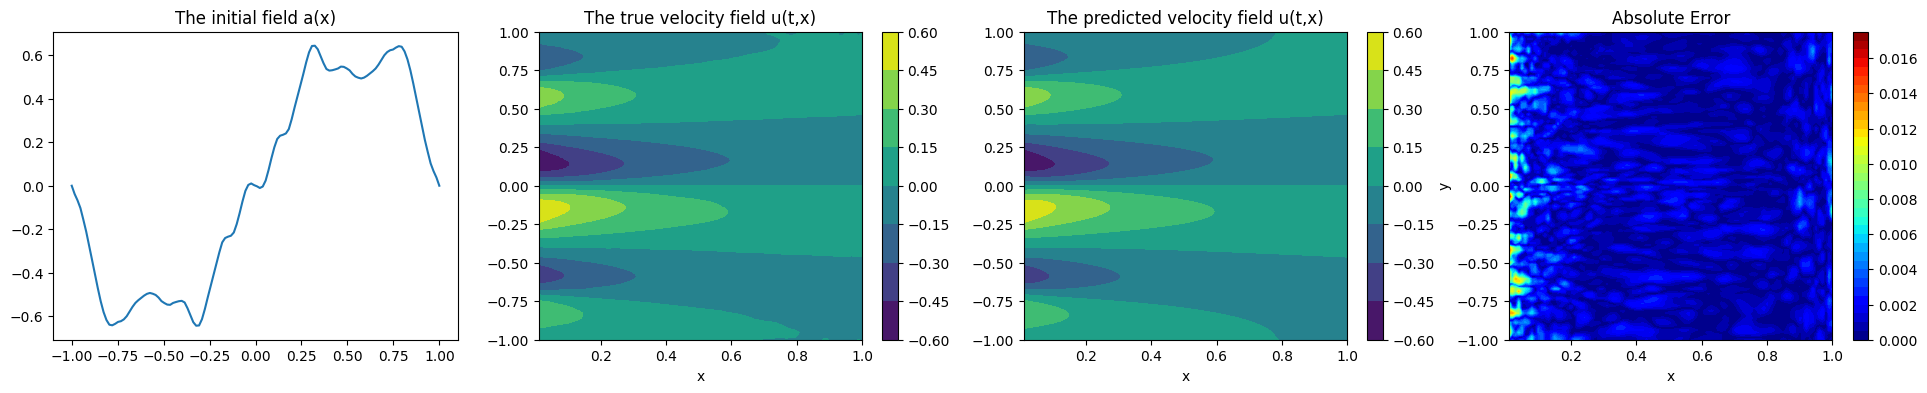

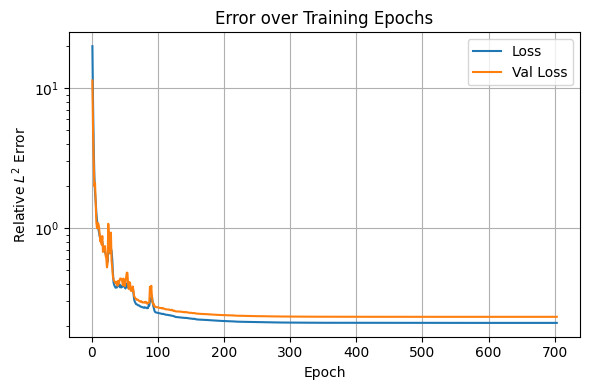

In [13]:
fig, axes = plt.subplots(1,4, figsize=(24,4))
#
cntr = axes[0].plot(x_mesh, a_train[0])
axes[0].set_title('The initial field a(x)')
#
cntr = axes[1].contourf(T, X, u_pred)
axes[1].set_title('The true velocity field u(t,x)')
axes.flat[:][1].set_xlabel('x')
plt.colorbar(cntr)
#
cntr = axes[2].contourf(T, X, u_test[inx].squeeze(-1))
axes[2].set_title('The predicted velocity field u(t,x)')
axes.flat[:][2].set_xlabel('x')
plt.colorbar(cntr)

cntr = axes[3].contourf(T, X, np.abs(u_pred - u_test[inx].squeeze(-1)), levels=40, cmap='jet')
fig.colorbar(cntr, ax=axes.flat[:][3])
axes.flat[:][3].set_title('Absolute Error')
axes.flat[:][3].set_xlabel('x')
axes.flat[:][3].set_ylabel('y')
plt.show()


plt.show()

# Plot training error over epochs
plt.figure(figsize=(6,4))
plt.plot(np.arange(1, epoch+2), loss_list, label='Loss')
plt.plot(np.arange(1, epoch+2), val_loss_list, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Relative $L^2$ Error')
plt.title('Error over Training Epochs')
plt.yscale('log')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()